# Amazon Reviews Sentiment Analysis
____________

# Part 2: EDA, Preprocessing

### Riche Ngo

In [149]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Import Data

In [150]:
# Use this to load previously saved .pkl file
infile = open('../datasets/amazon_reviews_electronics/Electronics_merged_2018.pkl', 'rb')
df = pickle.load(infile)
infile.close()

In [151]:
df.head()

overall   reviewTime      reviewerID        asin  \
0      5.0  01 27, 2018  A1XSPKZ8HHSBX2  073530498X   
1      5.0   04 1, 2018  A3G5NNV6T6JA8J  106171327X   
2      5.0  03 30, 2018   AFML7PYI3LERI  106171327X   
3      4.0  03 30, 2018  A1G0HYMR02WM2W  106171327X   
4      5.0  03 27, 2018  A1T8B3I8KRS3W0  106171327X   

                                          reviewText  \
0  I made a photo album for a senior friend who w...   
1  Great addition to our new Galaxy S9's which, b...   
2                                          Perfect !   
3                                      As described.   
4            Great little card made my device better   

                                       summary  unixReviewTime  \
0                                    great buy      1517011200   
1  Great addition to our new Galaxy S9's which      1522540800   
2                                   Five Stars      1522368000   
3                                   Four Stars      1522368000   
4                                   Five Stars      1522108800   

                                               title   main_cat  
0                         Vintage Camera Photo Album      Books  
1  Sandisk SDSDQUA-064G-A11 Professional Ultra 64...  Computers  
2  Sandisk SDSDQUA-064G-A11 Professional Ultra 64...  Computers  
3  Sandisk SDSDQUA-064G-A11 Professional Ultra 64...  Computers  
4  Sandisk SDSDQUA-064G-A11 Professional Ultra 64...  Computers

In [152]:
df.isnull().sum()

overall              0
reviewTime           0
reviewerID           0
asin                 0
reviewText           0
summary              0
unixReviewTime       0
title             1266
main_cat          1266
dtype: int64

In [153]:
df.dtypes

overall           float64
reviewTime         object
reviewerID         object
asin               object
reviewText         object
summary            object
unixReviewTime      int64
title              object
main_cat           object
dtype: object

## EDA

### Ratings

We want to understand the distribution of the ratings.

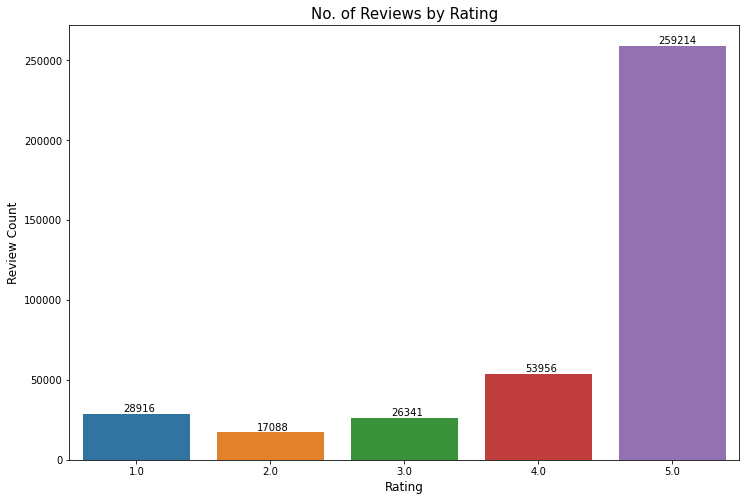

In [154]:
# Plot the number of reviews for each rating given
ratings = df['overall'].value_counts().reset_index().sort_values(by='index').reset_index(drop=True)
plt.figure(figsize=(12,8))
sns.barplot(x='index', y='overall', data=ratings)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Review Count', fontsize=12)
plt.title('No. of Reviews by Rating', fontsize=15)
for i in range(len(ratings['index'])):
    plt.text(i-0.1, ratings['overall'][i]+1000,'{}'.format(ratings['overall'][i]),size=10);

**Observations:**  
We observe that a large proportions of reviewers gave a maximum rating of 5.0, followed by rating of 4.0, then 1.0. Relatively, lesser reviewers gave a rating of 2.0 and 3.0. This suggests that people are mostly either very happy with the products or not.

For analysis, we will assume the following:  
* 3.0 Rating and below - Bad review
* 4.0 Rating - Neutral review
* 5.0 Rating - Good review

This will also be the target variable during analysis.

In [155]:
# Create a column to explain the rating as mentioned
df['target'] = df['overall'].map({5: 'Good',
                                 4: 'Neutral',
                                 3: 'Bad',
                                 2: 'Bad',
                                 1: 'Bad'})

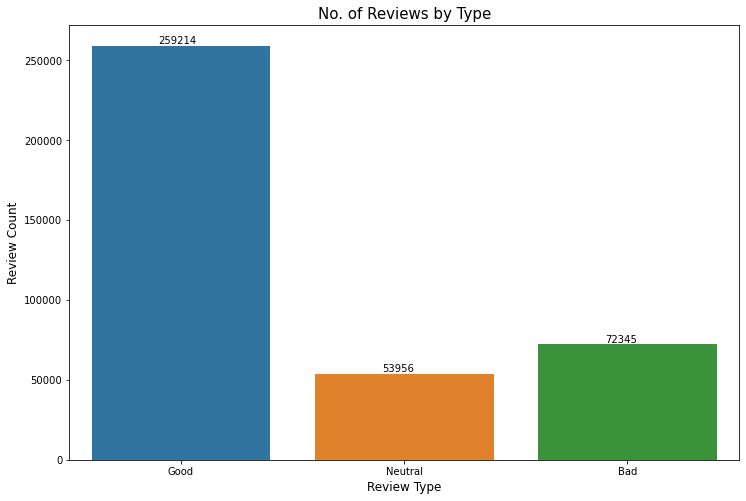

In [156]:
# Plot the number of reviews for each review type specified
review_types = df['target'].value_counts().loc[['Good', 'Neutral', 'Bad']]
plt.figure(figsize=(12,8))
sns.barplot(x=review_types.index, y=review_types.values)
plt.xlabel('Review Type', fontsize=12)
plt.ylabel('Review Count', fontsize=12)
plt.title('No. of Reviews by Type', fontsize=15)
for i in range(len(review_types.values)):
    plt.text(i-0.1, review_types.values[i]+1000,'{}'.format(review_types.values[i]),size=10);

### Reviews over Time

We understand that each review represents an item sold on Amazon. We could observe the number of reviews over the year of 2018.

In [157]:
# Convert column into datetime
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

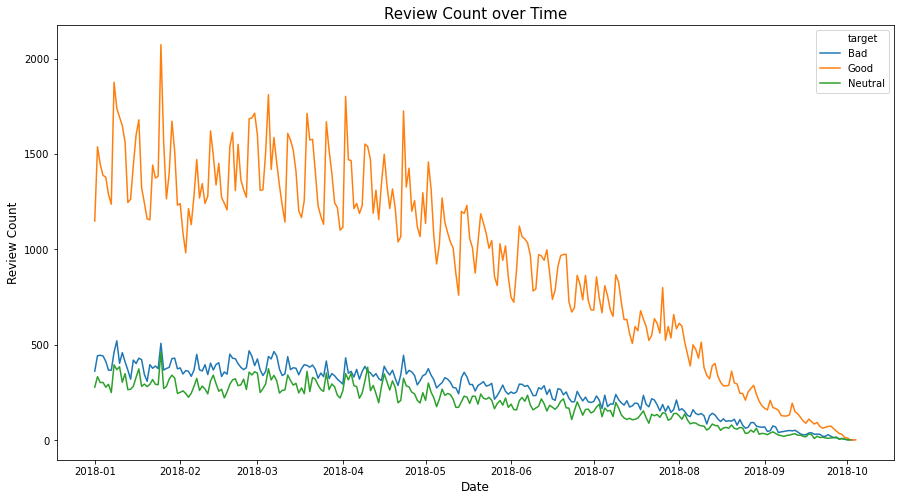

In [158]:
# Products sales in the year 2018
product_sales = df.groupby(by=['reviewTime', 'target']).count().reset_index()
plt.figure(figsize=(15,8))
sns.lineplot(x='reviewTime', y='overall', data=product_sales, hue='target')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Review Count', fontsize=12)
plt.title('Review Count over Time', fontsize=15);

**Observations:**  
We observe that there is a downward trend in review counts across the year of 2018.

### Bigrams

In [159]:
# Function to extract top bigrams
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [160]:
# Extract the top 30 bigrams for each review type
bigrams_good = pd.DataFrame(get_top_n_bigram(df.loc[df['target']=='Good', 'reviewText'], 30), columns=['bigrams', 'count'])
bigrams_neutral = pd.DataFrame(get_top_n_bigram(df.loc[df['target']=='Neutral', 'reviewText'], 30), columns=['bigrams', 'count'])
bigrams_bad = pd.DataFrame(get_top_n_bigram(df.loc[df['target']=='Bad', 'reviewText'], 30), columns=['bigrams', 'count'])

In [161]:
# Set the index of the dataframes to be the bigrams
bigrams_good.set_index('bigrams', inplace=True)
bigrams_neutral.set_index('bigrams', inplace=True)
bigrams_bad.set_index('bigrams', inplace=True)

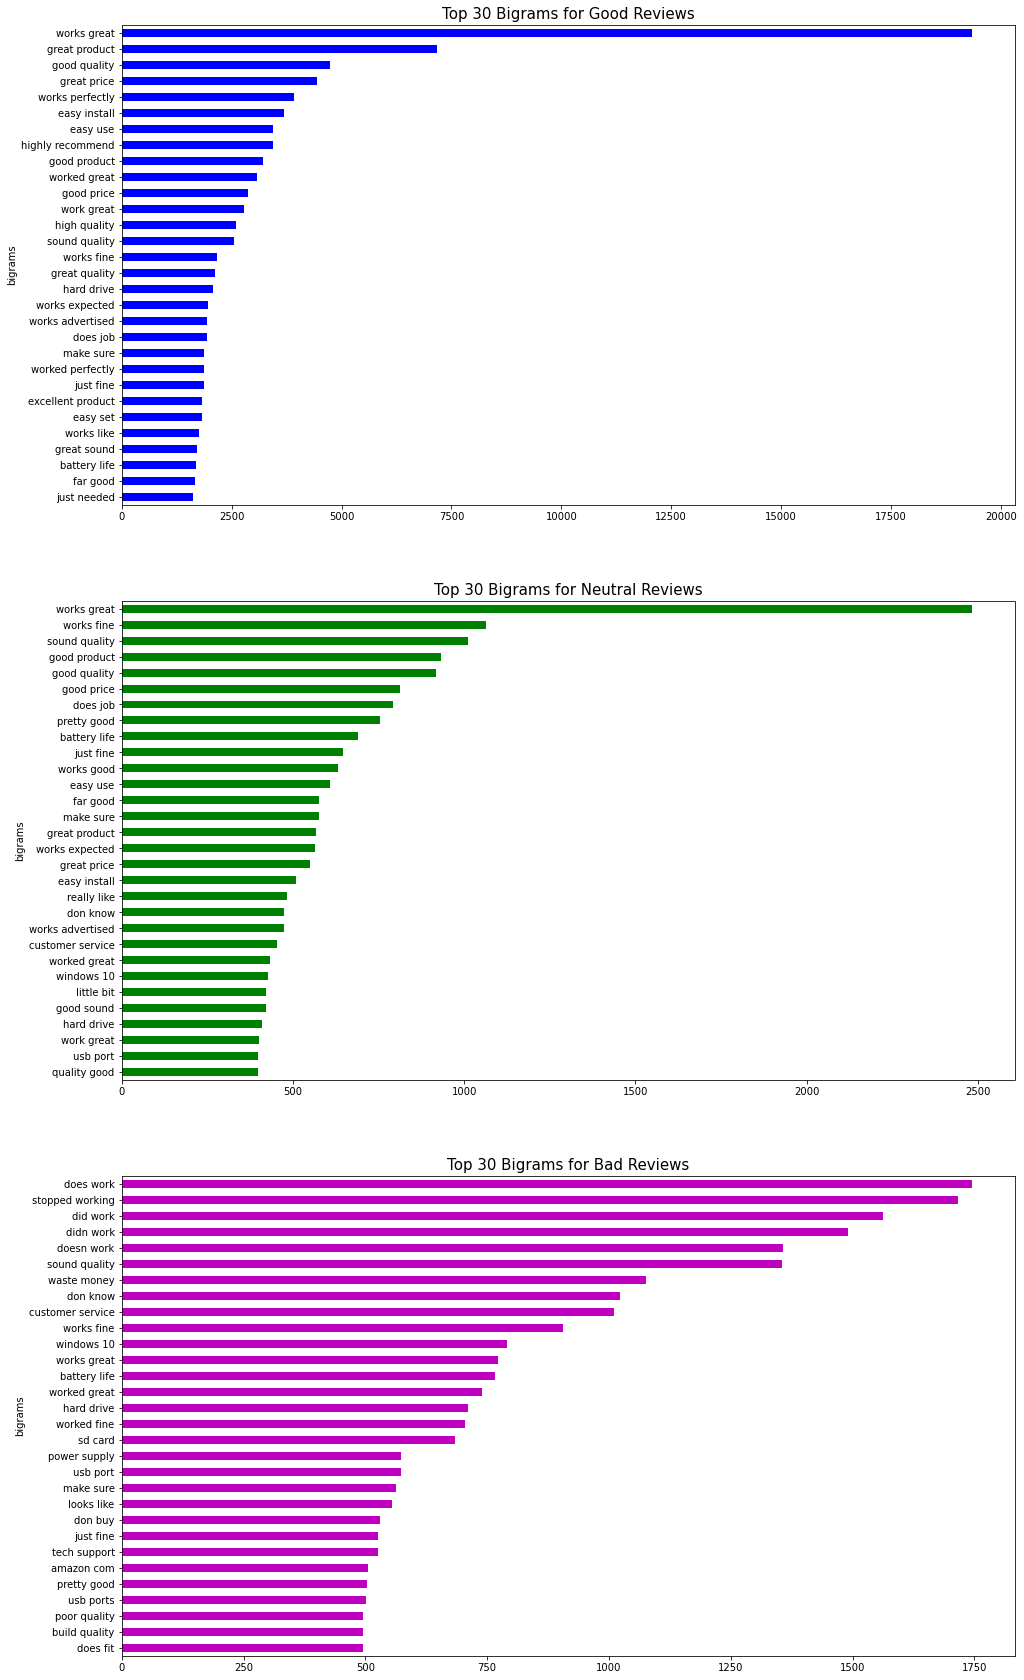

In [162]:
# Visualize top 30 bigrams using bar plot
fig, ax = plt.subplots(3, 1, figsize=(16, 30))

bigrams_good.plot(kind='barh', ax=ax[0], color='b')
ax[0].invert_yaxis()
ax[0].set_title('Top 30 Bigrams for Good Reviews', fontsize=15)
ax[0].legend().remove()

bigrams_neutral.plot(kind='barh', ax=ax[1], color='g')
ax[1].invert_yaxis()
ax[1].set_title('Top 30 Bigrams for Neutral Reviews', fontsize=15)
ax[1].legend().remove()

bigrams_bad.plot(kind='barh', ax=ax[2], color='m')
ax[2].invert_yaxis()
ax[2].set_title('Top 30 Bigrams for Bad Reviews', fontsize=15)
ax[2].legend().remove();

**Observations:**  
INSERT

### Trigrams

In [163]:
# Function to extract top bigrams
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [164]:
# Extract the top 20 trigrams for each review type
trigrams_good = pd.DataFrame(get_top_n_trigram(df.loc[df['target']=='Good', 'reviewText'], 20), columns=['trigrams', 'count'])
trigrams_neutral = pd.DataFrame(get_top_n_trigram(df.loc[df['target']=='Neutral', 'reviewText'], 20), columns=['trigrams', 'count'])
trigrams_bad = pd.DataFrame(get_top_n_trigram(df.loc[df['target']=='Bad', 'reviewText'], 20), columns=['trigrams', 'count'])

In [165]:
# Set the index of the dataframes to be the trigrams
trigrams_good.set_index('trigrams', inplace=True)
trigrams_neutral.set_index('trigrams', inplace=True)
trigrams_bad.set_index('trigrams', inplace=True)

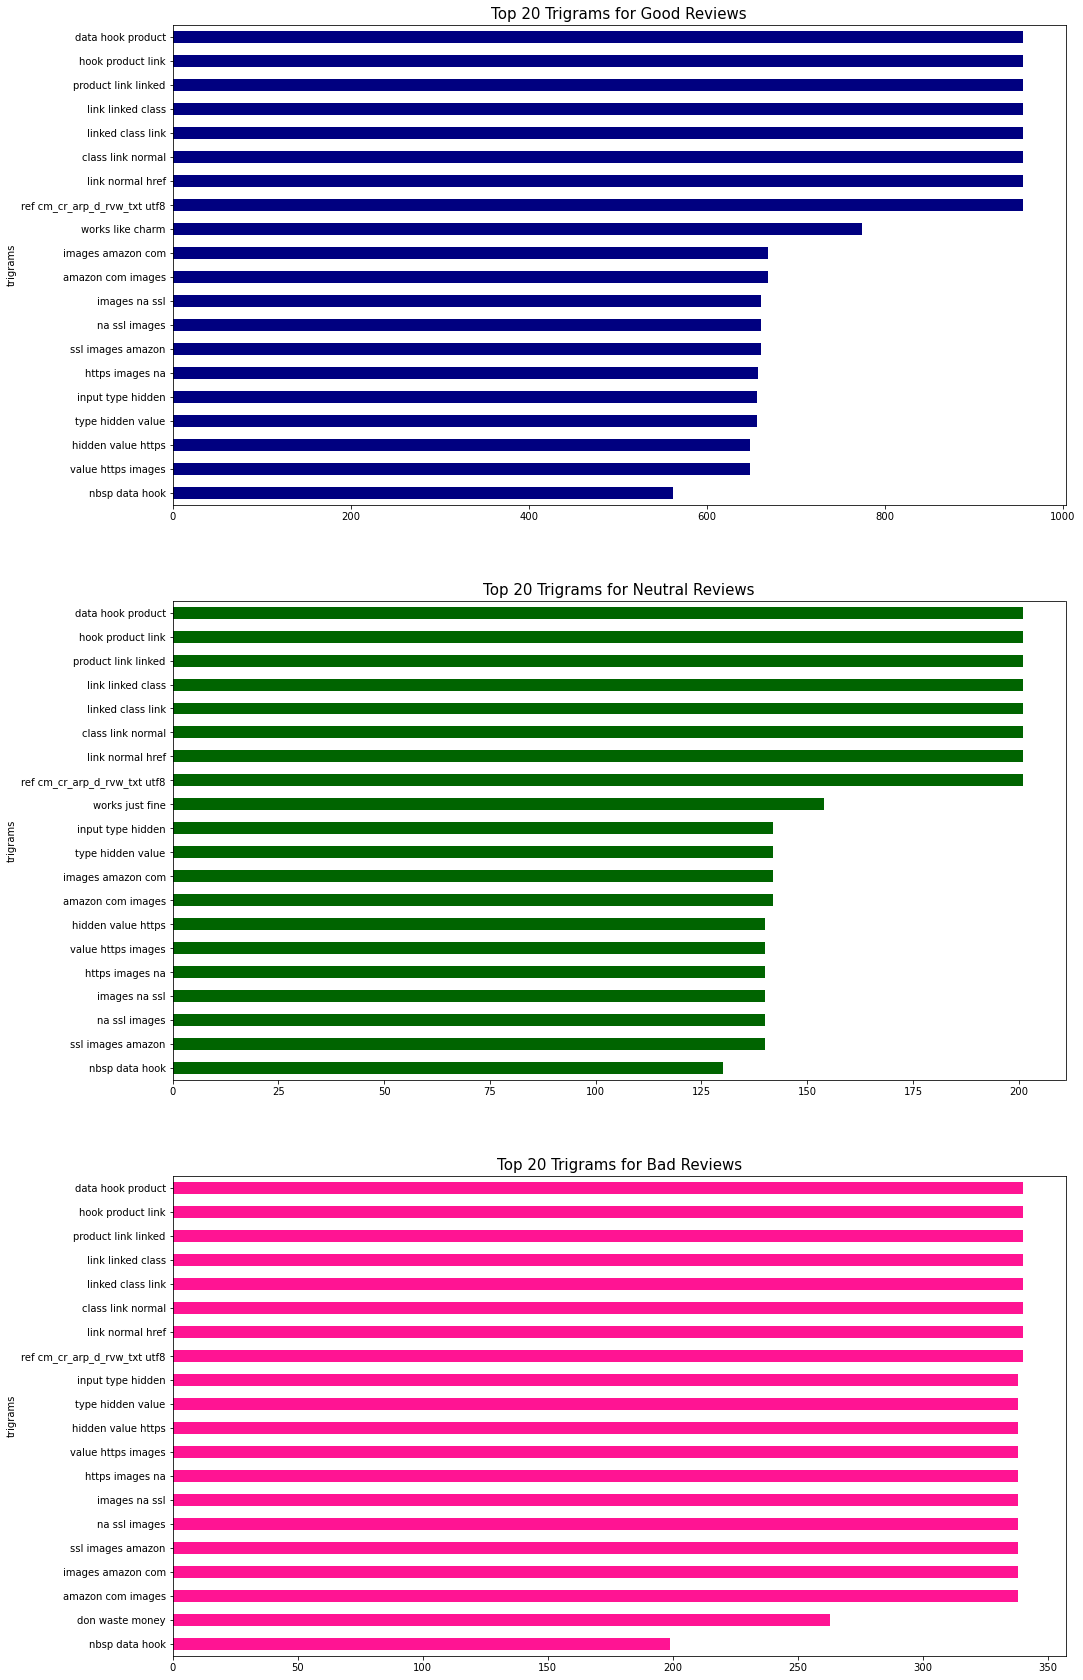

In [166]:
# Visualize top 30 trigrams using bar plot
fig, ax = plt.subplots(3, 1, figsize=(16, 30))

trigrams_good.plot(kind='barh', ax=ax[0], color='navy')
ax[0].invert_yaxis()
ax[0].set_title('Top 20 Trigrams for Good Reviews', fontsize=15)
ax[0].legend().remove()

trigrams_neutral.plot(kind='barh', ax=ax[1], color='darkgreen')
ax[1].invert_yaxis()
ax[1].set_title('Top 20 Trigrams for Neutral Reviews', fontsize=15)
ax[1].legend().remove()

trigrams_bad.plot(kind='barh', ax=ax[2], color='deeppink')
ax[2].invert_yaxis()
ax[2].set_title('Top 20 Trigrams for Bad Reviews', fontsize=15)
ax[2].legend().remove();

**Observations:**  
INSERT

## Length of Reviews

In [167]:
# Function to output the length of each review
# in a Series
def posts_to_lengths(list_of_reviews):
    length_list = []
    for review in list_of_reviews:
        length_list.append(len(review.split()))
    return pd.Series(length_list)

In [168]:
# Lengths of reviews for each review type
review_lengths_good = posts_to_lengths(df.loc[df['target']=='Good', 'reviewText'])
review_lengths_neutral = posts_to_lengths(df.loc[df['target']=='Neutral', 'reviewText'])
review_lengths_bad = posts_to_lengths(df.loc[df['target']=='Bad', 'reviewText'])

In [169]:
review_lengths_good.describe()

count    259214.000000
mean         30.190854
std          56.546552
min           1.000000
25%           5.000000
50%          13.000000
75%          33.000000
max        3239.000000
dtype: float64

In [170]:
review_lengths_neutral.describe()

count    53956.000000
mean        48.623805
std         85.394280
min          1.000000
25%          7.000000
50%         22.000000
75%         56.000000
max       4218.000000
dtype: float64

In [171]:
review_lengths_bad.describe()

count    72345.000000
mean        57.391679
std         80.818992
min          1.000000
25%         13.000000
50%         32.000000
75%         70.000000
max       2170.000000
dtype: float64

We observed that for each review type, the maximum length of one review is very high (> 2000). These reviews are clearly outliers.

In [172]:
# Check out one of the reviews with the longest length
df.loc[df['target']=='Good'].reset_index(drop=True).loc[review_lengths_good[review_lengths_good >3000].index, 'reviewText'].values

array(["To start, I would say if you are looking at the 80D then you should be someone that does one or more of the following:\n1. You shoot a lot of video (weekly basis minimum), and need the added headphone jack.\n2. You shoot a lot of action (Sports, wildlife, anything that moves fast and is hard to track), but don't want to shell out for a 7DmkII.\n3. You get paid for your photography or are very serious about the hobby, or at least have a lot of disposable income.\nI say all this because this is an expensive camera, and is so because it is loaded with features and has a solid build.  For people that are not out shooting all the time than it is likely too expensive for what you are doing.  For those that are doing those things then it very well could be the best value in an APS-C camera before you get to the more expensive offerings like the 7D or go to a full frame.  With that said, lets get started.\n\nAs with all WOFG photography reviews, I have a lot to say here.  I will start 

Although the review may seem useful to the users of Amazon, it is too long and contains way too many words in comparison to the average number of words across all the reviews.

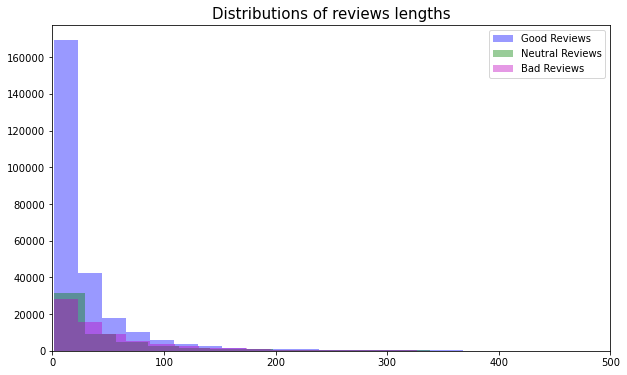

In [173]:
# Plot distribution of lengths of reviews
plt.figure(figsize=(10,6))
ax = plt.gca()
sns.distplot(review_lengths_good, bins=150, kde=False, color='b', ax=ax, label='Good Reviews')
sns.distplot(review_lengths_neutral, bins=150, kde=False, color='g', ax=ax, label='Neutral Reviews')
sns.distplot(review_lengths_bad, bins=100, kde=False, color='m', ax=ax, label='Bad Reviews')
ax.set_title('Distributions of reviews lengths', fontsize=15)
ax.legend()
plt.xlim(0, 500);

The distributions of reviews regardless of the review type are very similar to each other, with an average number of words of around 30 to 60 words.

## Preprocessing

In [174]:
# Defining the stopwords list
stopwords_list = stopwords.words('english')
stopwords_list.extend(['utf8', 'ref'])

In [175]:
def preprocess_text(text, stopwords_list):
    ''' Function to convert a text to a string of preprocessed words
    The input is a single string and 
     the output is a single string (preprocessed)'''
    
    # 1. Remove punctuation and digits.
    words_only = re.sub("[^\w\s]", " ", text)
    words_only = re.sub("[\w]*\d+", " ", words_only)
    
    # 2. Convert to lower case, split into individual words.
    words = words_only.lower().split()
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords_list)
    
    # 4. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5. Lemmatizing.
    lemmatizer = WordNetLemmatizer()
    meaningful_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [176]:
# Preprocess the reviews
meaningful_reviews_good = [preprocess_text(text, stopwords_list) for text in df.loc[df['target']=='Good', 'reviewText']]
meaningful_reviews_neutral = [preprocess_text(text, stopwords_list) for text in df.loc[df['target']=='Neutral', 'reviewText']]
meaningful_reviews_bad = [preprocess_text(text, stopwords_list) for text in df.loc[df['target']=='Bad', 'reviewText']]

In [177]:
meaningful_reviews_good[:2]

['made photo album senior friend moving really liked old camera picture style small album great buy',
 'great addition new galaxy way come sd medium able transfer data old phone sd card quickly easily']

### Word Clouds

In [178]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud, interpolation='bilinear') 
    # No axis details
    plt.axis("off");

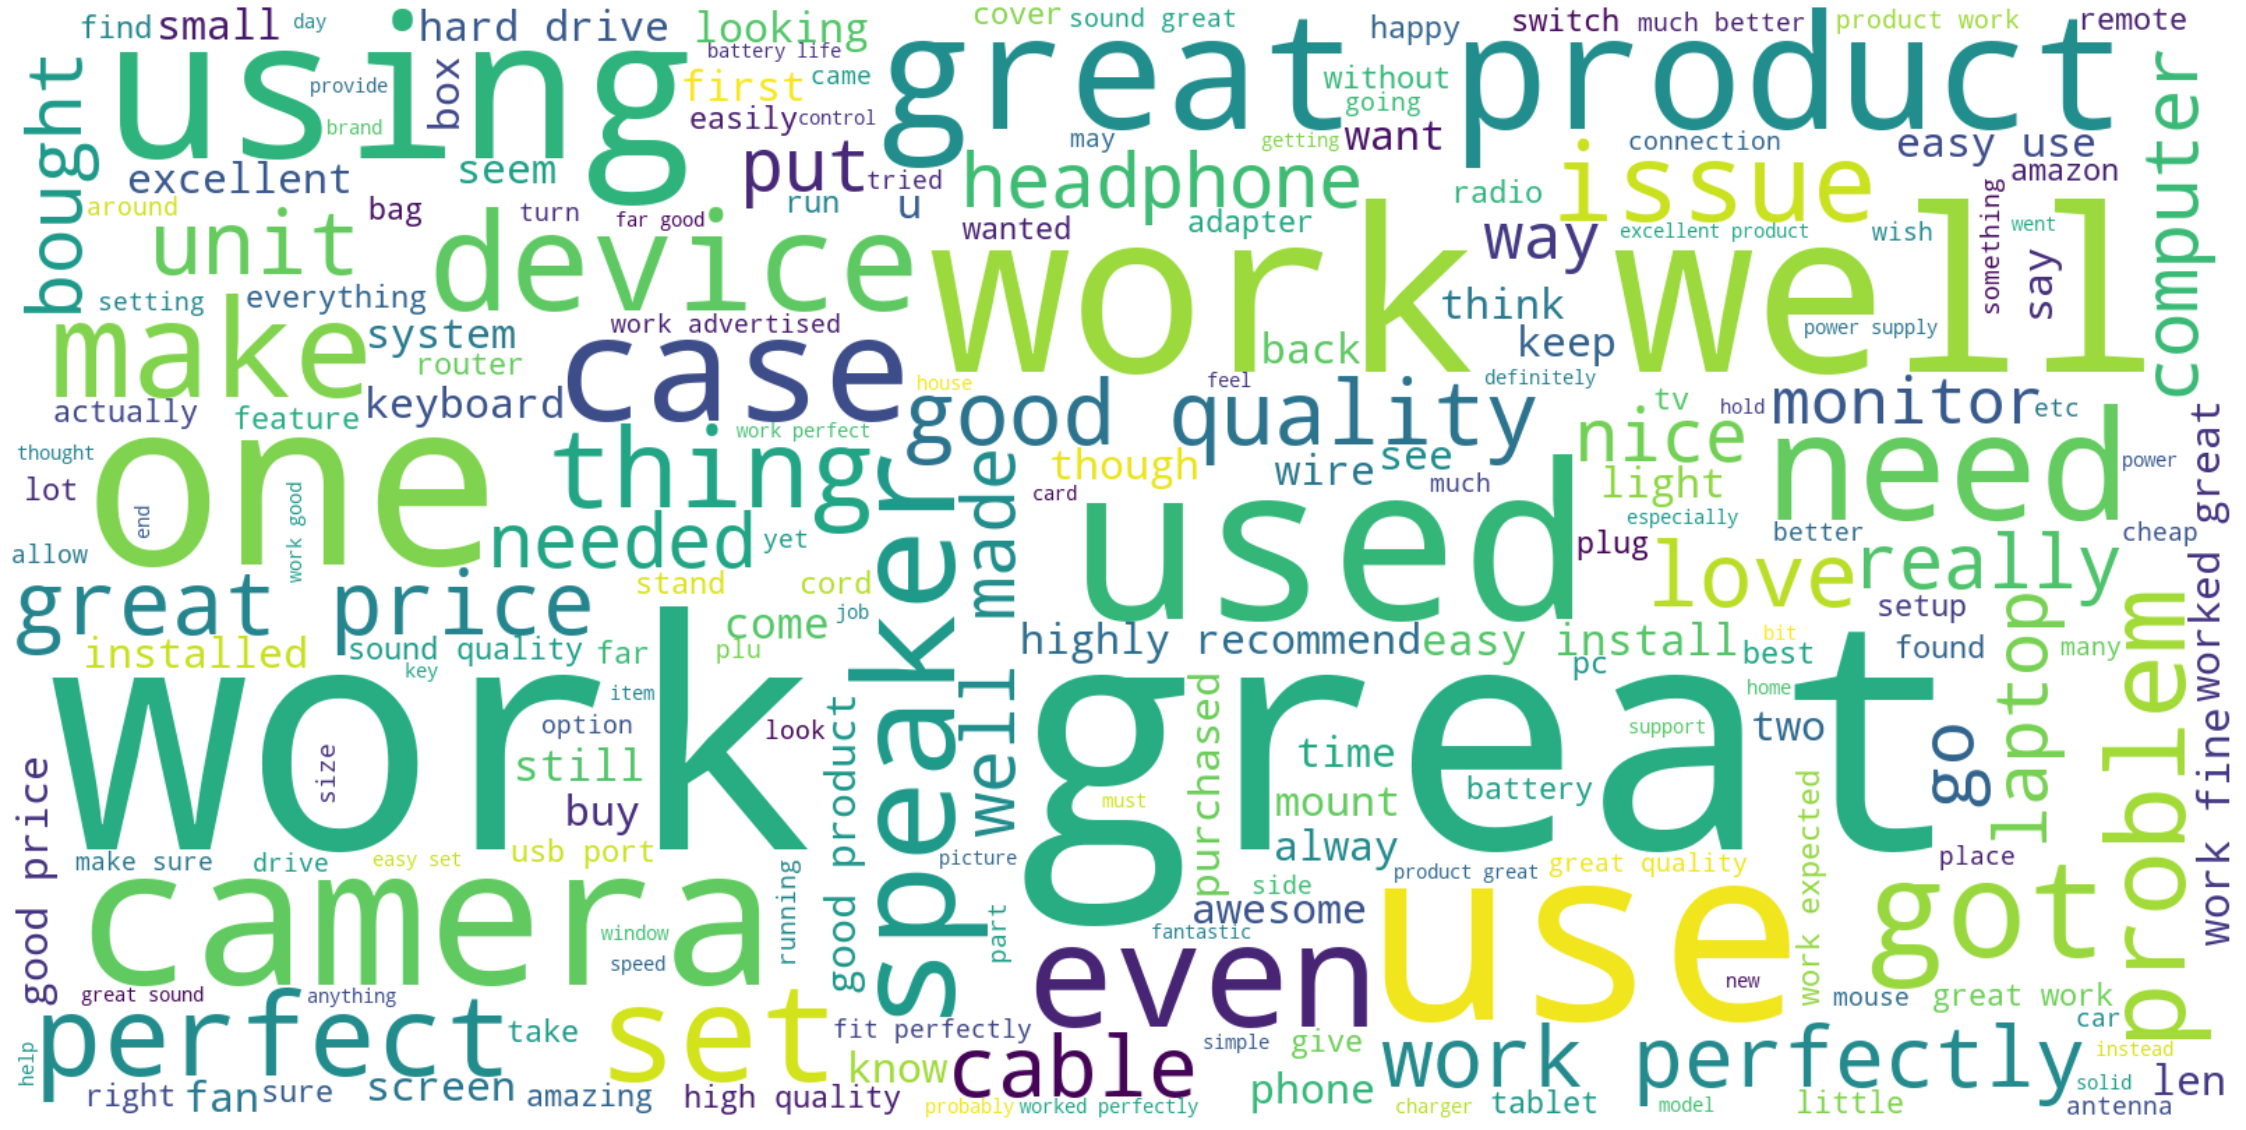

In [179]:
# Plotting wordcloud for good reviews
text = " ".join(meaningful_reviews_good)
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(text)

# Plot
plot_cloud(wordcloud)

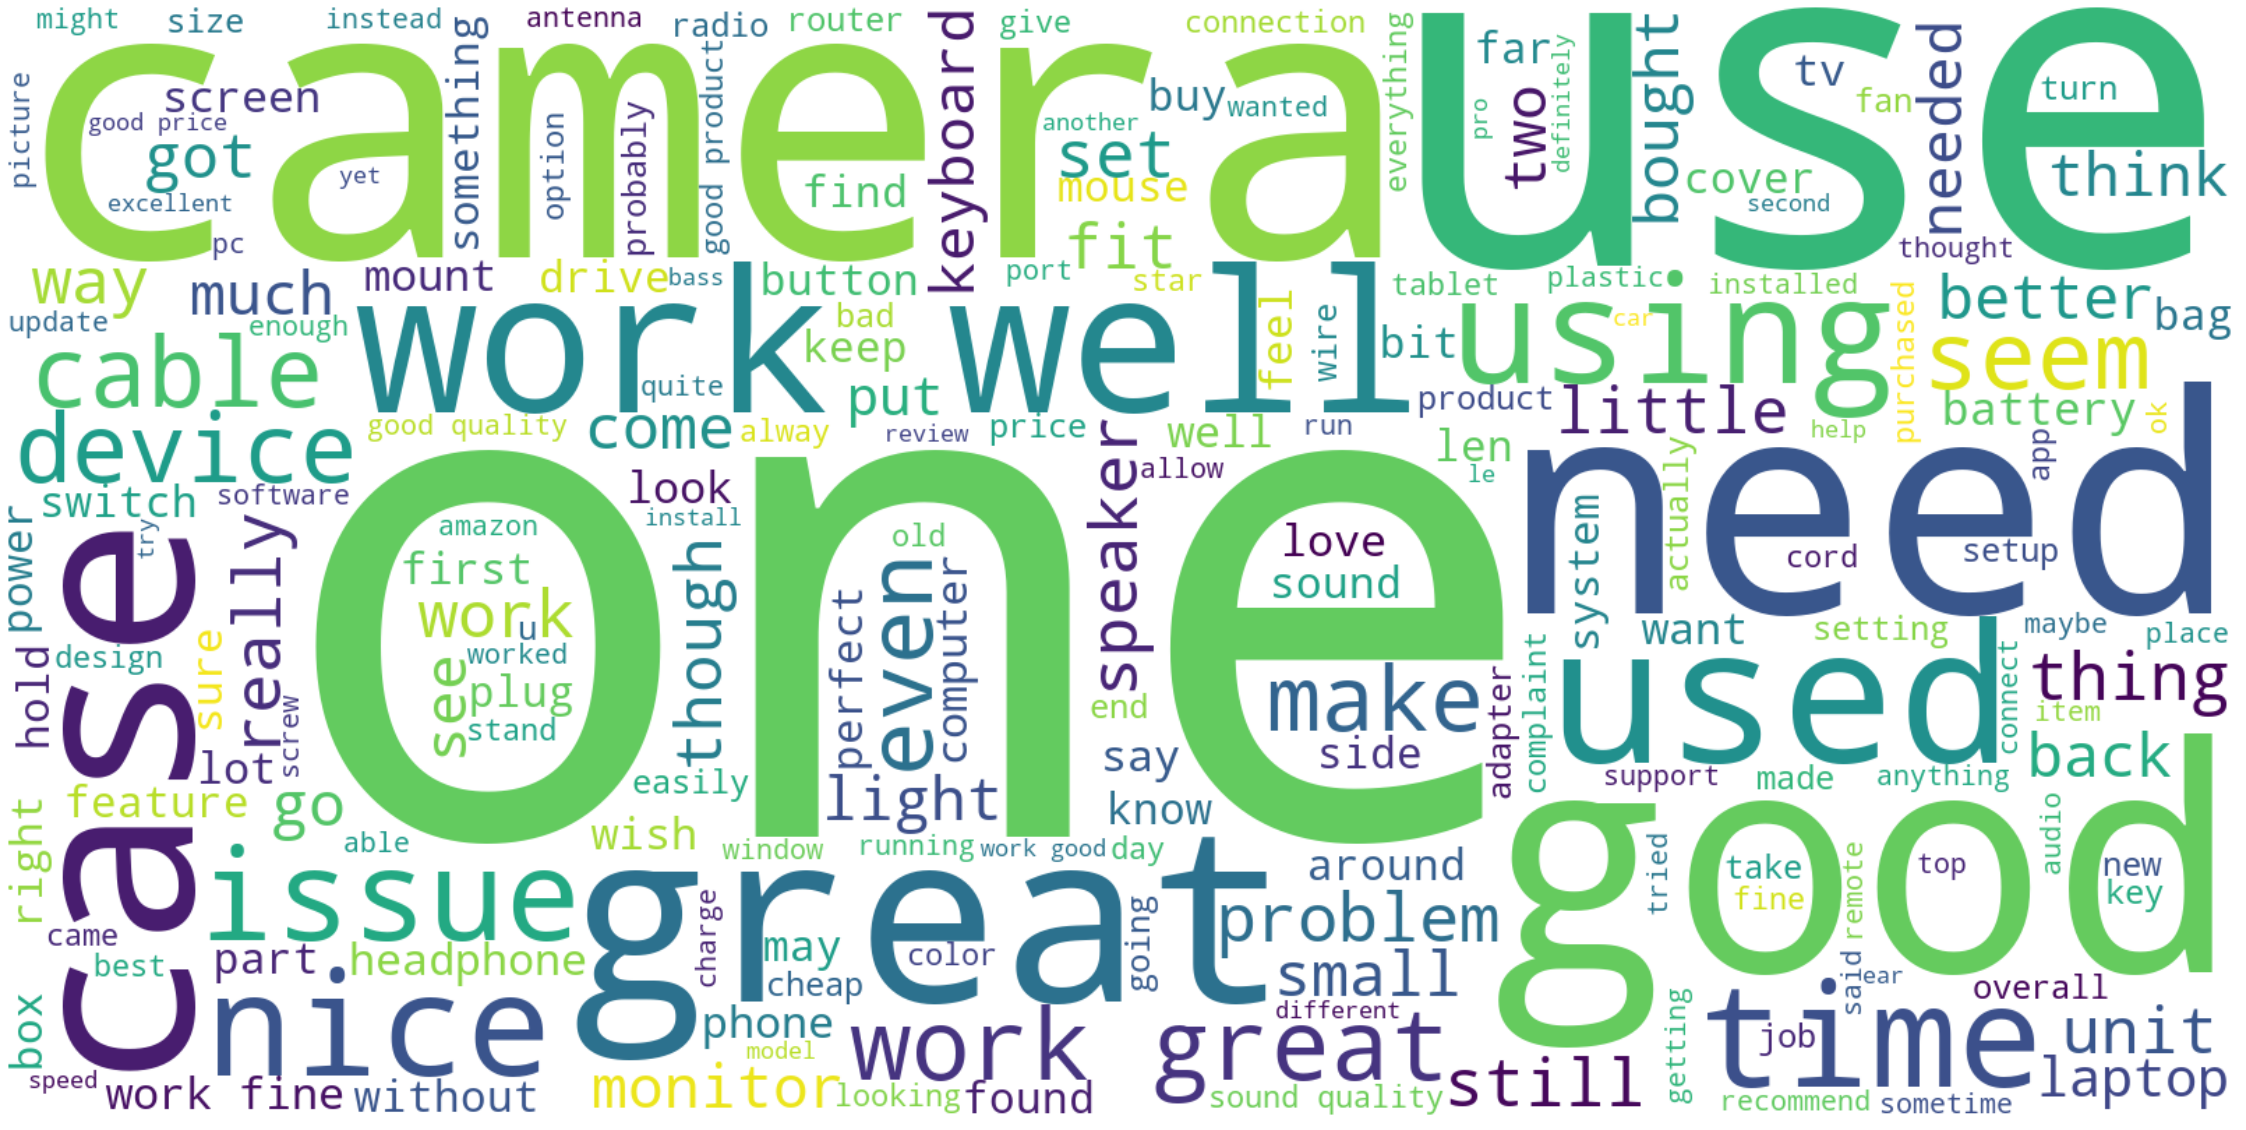

In [180]:
# Plotting wordcloud for neutral reviews
text = " ".join(meaningful_reviews_neutral)
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(text)

# Plot
plot_cloud(wordcloud)

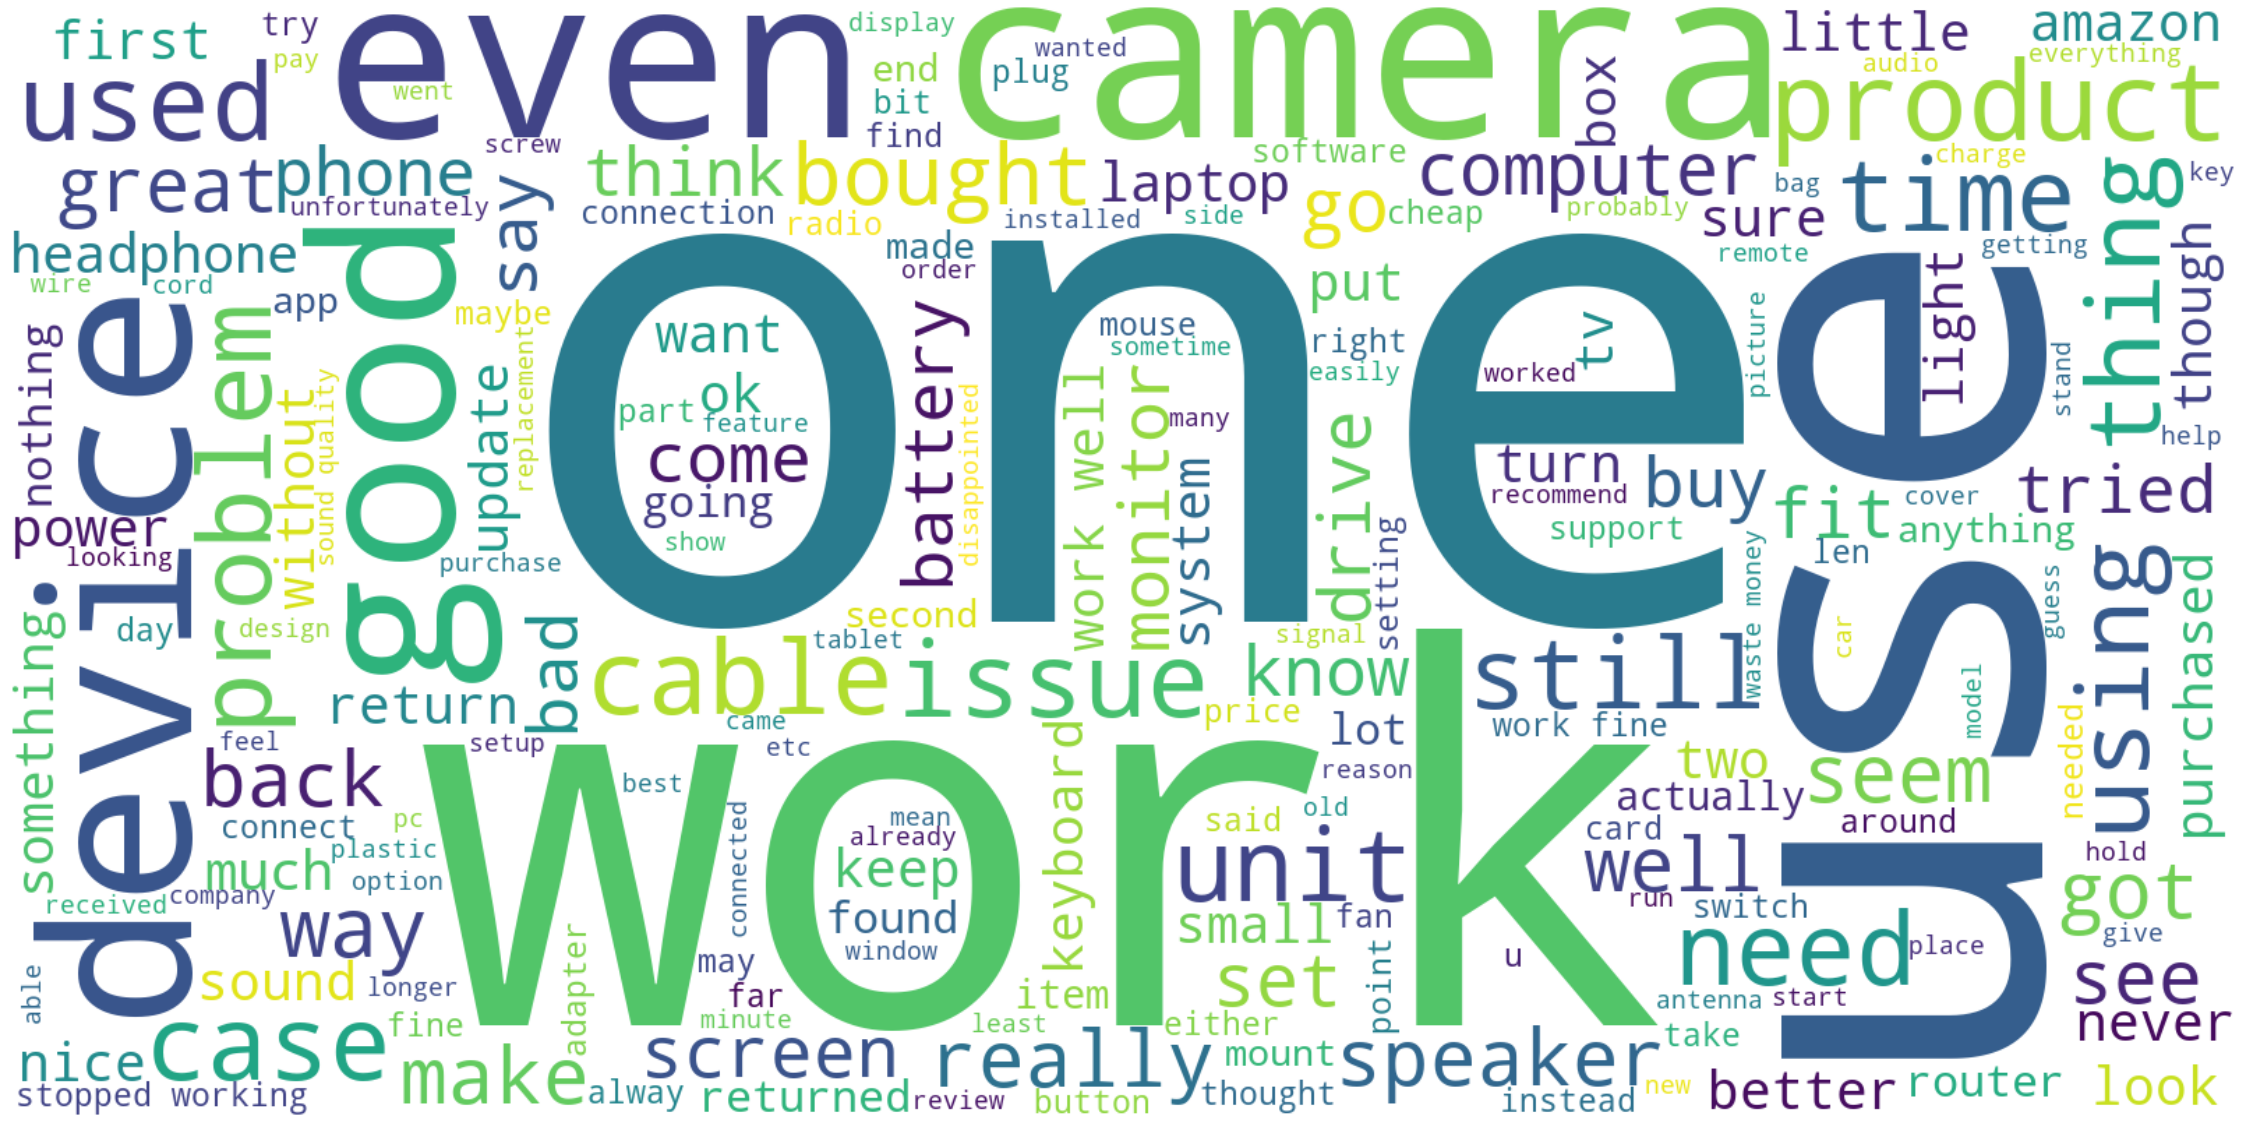

In [181]:
# Plotting wordcloud for bad reviews
text = " ".join(meaningful_reviews_bad)
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(text)

# Plot
plot_cloud(wordcloud)

In [182]:
# Save the preprocessed reviews as a dataframe
preprocessed_good = pd.DataFrame(meaningful_reviews_good, columns=['reviews'])
preprocessed_good['target'] = 'Good'
preprocessed_neutral = pd.DataFrame(meaningful_reviews_neutral, columns=['reviews'])
preprocessed_neutral['target'] = 'Neutral'
preprocessed_bad = pd.DataFrame(meaningful_reviews_bad, columns=['reviews'])
preprocessed_bad['target'] = 'Bad'

preprocessed_reviews = pd.concat([preprocessed_good, preprocessed_neutral, preprocessed_bad], axis=0)

In [183]:
preprocessed_reviews.shape

(385515, 2)

In [186]:
preprocessed_reviews.head()

reviews target
0  made photo album senior friend moving really l...   Good
1  great addition new galaxy way come sd medium a...   Good
2                                            perfect   Good
3               great little card made device better   Good
4                       item described fast shipping   Good

In [185]:
# Save dataframe as pickle
outfile = open('../datasets/amazon_reviews_electronics/meaningful_reviews.pkl','wb')
pickle.dump(meaningful_reviews, outfile)
outfile.close()

In [187]:
# Save dataframe as pickle
outfile = open('../datasets/amazon_reviews_electronics/preprocessed_reviews.pkl','wb')
pickle.dump(preprocessed_reviews, outfile)
outfile.close()